In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import joblib
import time

In [3]:
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)

# print(mnist.DESCR)

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications. The MNIST database was constructed from NIST's NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.  

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint. SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 is available and we used this information to unscramble the writers. We then split SD-1 in two: characters written by the first 250 writers went into our new training set. The remaining 250 writers were placed in our test set. Thus we had two sets with nearly 30,000 examples each. The new training set was completed with enough examples from SD-3, starting at pattern # 0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern # 35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000 sample training set is available.

In [4]:
X = mnist["data"]
y = mnist["target"]

In [5]:
X.shape

(70000, 784)

70 000 28x28 bilder 

In [6]:
rs = 42

# skapar train (60%) och temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=rs,
    stratify=y
)

# delar temp i val (20%) och test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=rs,
    stratify=y_temp
)

In [7]:
print(X_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


## EDL

In [8]:
pd.Series(y_train).value_counts().sort_index()

0    4142
1    4726
2    4194
3    4284
4    4094
5    3788
6    4126
7    4376
8    4095
9    4175
Name: count, dtype: int64

In [9]:
df = pd.DataFrame(X_train)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.203000,0.093786,0.039452,0.020571,0.021071,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.251423,4.116166,2.546716,1.784560,2.003036,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,252.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


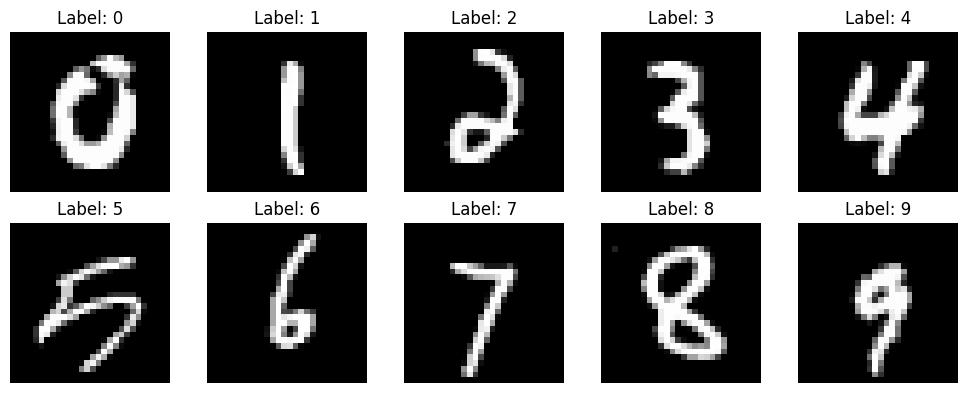

In [31]:
#titta på en bild per label (siffra)
plt.figure(figsize=(10,4))

for digit in range(10):
    
    idx = np.where(y_train == str(digit))[0][0]  # hitta första index där label == digit

    plt.subplot(2,5,digit+1)
    plt.imshow(X_train[idx].reshape(28,28), cmap="gray")
    plt.title(f"Label: {digit}")
    plt.axis("off")

plt.tight_layout()
plt.show()


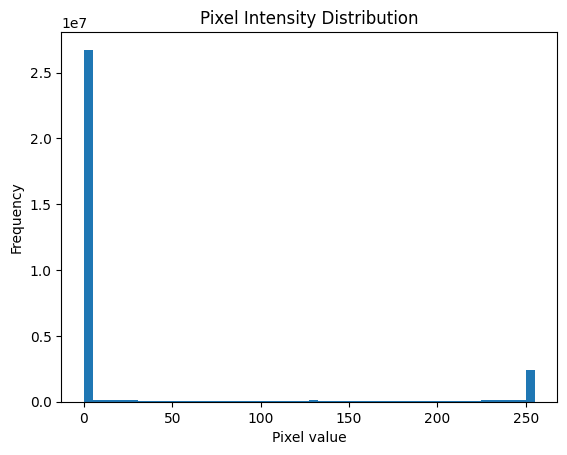

In [12]:
plt.hist(X_train.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

Majoriteten av färgvärdet i datan är 0 (svart/mörk) och lite är 255 (vit/ljus). Väldigt lite är mittemellan-värden (gråa). 

In [ ]:
# normaliserar pixelvärdena till skalan 0-1. Det här förändrar inte relationerna mellan datapunkterna, det förändrar bara skalan till att bli mindre. 
# Vilket gör det lättare för matten i många modeller att arbeta.   
# Det här går att göra på all data, då ingen faktisk "kunskap" om datasettet krävs (dvs, vi "tjuvkikar inte på något") - allt delas bara med 255. 

X_train = X_train.astype(np.float32) / 255.0
X_val   = X_val.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Modell 1 - Logistic regression
Börjar med Logistic regression som baseline

In [ ]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()), # det behövs egentligen inte en scaler här, eftersom jag redan gjort om till 0-1, samt att det inte är olika "skala" på datan 
                                  # (tex inte "4 rum" & "pris 4 000 000") som behöver "plattas ut"
                                  # men vi har pratat om det på lektionerna, så tyckte det var kul att ta med :) 
    ("model", LogisticRegression(
        max_iter=1000   #Läste online att detta skulle vara ett bra värde för MNIST för att modellen ska hinna konvergera
        # man skulle också kunna sätta tex solver för att vara säker på att modellen är replikerbar (om de tex ändrar defaultbeteendena) 
        # men jag vet redan att jag inte kommer gå vidare med den här modellen, så det känns överflödigt. 
    ))
])

pipe_lr

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [15]:
pipe_lr.fit(X_train, y_train)

lr_val_acc = pipe_lr.score(X_val, y_val)
lr_val_acc

0.907

In [16]:
model = pipe_lr.named_steps["model"]
print("Antal iterationer:", model.n_iter_)

Antal iterationer: [186]


Modellen hann konvergera med god marginal (186 < 1000)

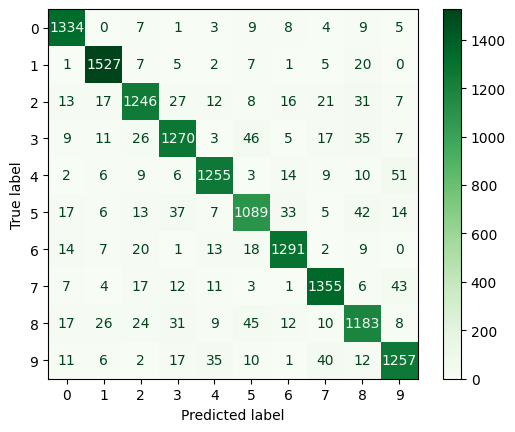

In [17]:

y_test_pred_lr = pipe_lr.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.show()

Modeller har svårt att skilja på siffror som har liknande "beståndsdelar", t.ex. 3 & 5, 3 & 8. Gör mycket sällan fel på mer olika siffror (t.ex. 1 & 0, 2 & 9)
Logistic Regression användes som en baseline-modell för att få en referensnivå, så jag prioriterade inte någon hyperparameter-tuning här, eftersom min dator är långsam. 

## Modell 2 - SVC

Jag jämförde modellerna först utan tuning och/eller PCA för att få en baseline, utifrån att det tar lång tid för att beräkningarna att köra. Jag går bara vidare och laborerar med den av modellerna som har bäst accuracy, vilket visar sig vara SVC. Det är inte en helt rättvis jämförelse, men det känns heller inte rimligt att förvänta sig att siffrorna i datasettet skulle vara linjärt separerbara (vilken ju är poängen med logistic regression).

Jag laborerade sen med att köra modellen med och utan PCA och kom fram till att det gick mycket snabbare (ca halva tiden) *med* PCA, samt att accuracyn blev bättre (se värden nedan). Jag behöll därför den i Pipelinen. Från ursprungliga körningen (med kod som jag nu skrivit över/om):

Tid (s),    Accuracy

(106.72s, 0.9615714285714285)

(207.98s, 0.9591428571428572)

In [18]:
pipe_svc_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=rs)), 
    ("model", SVC(kernel="rbf", probability=True)) # probability=True så att jag kan använda detta i Streamlit appen 
])

In [19]:
#dataset som inkluderar val, för CV 
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

In [20]:
#Definera vilka rader som är val (0) och vilka som är train (-1), så jag kan förbestämma train/val-split, så att GridSearch går snabbare att köra (eftersom den då bara behöver köra på den förutbestämda splitten)
test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
ps = PredefinedSplit(test_fold=test_fold)

In [ ]:
#Försök 4
param_grid = {
    "pca__n_components": [0.90],
    "model__C": [10],
    "model__gamma": [0.0011, 0.001]
}

# #Försök 3
# param_grid = {
#     "pca__n_components": [0.90],
#     "model__C": [10],
#     "model__gamma": ["scale", 0.002, *0.001*]
# }

# #Försök 2
# param_grid = {
#     "pca__n_components": [0.90],
#     "model__C": [5, *10*, 15],
#     "model__gamma": [*"scale"*, 0.02]
# }

#Försök 1 
# param_grid = {
#     "pca__n_components": [*0.90*, 0.95],
#     "model__C": [1, 3, *10*],
#     "model__gamma": [*"scale"*, 0.01]
# } 
# körde denna med 3 folds, inte med predefined split
# scale = 0.0015484521883518858

In [22]:
grid_ps = GridSearchCV(
    estimator=pipe_svc_pca,
    param_grid = param_grid,
    scoring="accuracy",
    cv=ps,  # använd min prefit ovan som validering
    n_jobs=-1, # säger till koden att köra på CPU-kärnor jag inte är säker på att jag har
    verbose=3, # ger lite mer info för varje körning
    refit=True  # efter bästa params hittats tränar den om modellen på all data i train+val
)

In [23]:
grid_ps.fit(X_trainval, y_trainval)

Fitting 1 folds for each of 2 candidates, totalling 2 fits


,estimator,Pipeline(step...ility=True))])
,param_grid,"{'model__C': [10], 'model__gamma': [0.0011, 0.001], 'pca__n_components': [0.9]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,"PredefinedSpl...ape=(56000,)))"
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [24]:
best_model = grid_ps.best_estimator_
best_param = grid_ps.best_params_
val_acc = grid_ps.best_score_ 

In [25]:
print("Bästa hyperparametrarna:", best_param)
print("Accuracy på valideringsdatan:", val_acc)
print("Gamma som modellen använder:", best_model.named_steps["model"]._gamma)

Bästa hyperparametrarna: {'model__C': 10, 'model__gamma': 0.0011, 'pca__n_components': 0.9}
Accuracy på valideringsdatan: 0.9698571428571429
Gamma som modellen använder: 0.0011


Nu skulle jag kunna köra GridSearchCV fler gånger för att se om jag kan få fram en ännu bättre modell genom att fortsätta iterera utifrån de värden jag fick. Jag skulle kunna fortsätta försöka hitta bättre värden för C, samt kanske kolla om det är värt att gå upp till 0.95 för pca igen. 

Men det tog jättelång tid att köra det jag redan har och jag tycker att min accuracy duger bra. 
Jag går vidare till en slutgiltig koll på testdatan. 

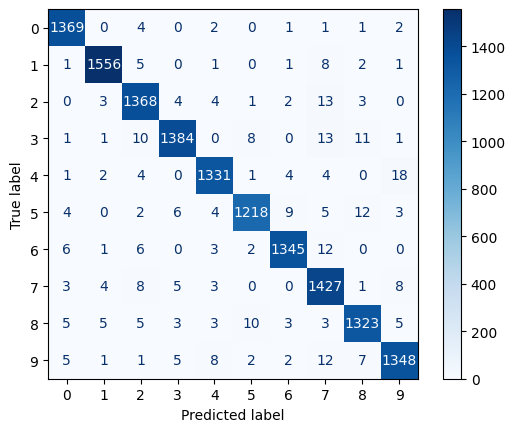

In [26]:
y_test_pred = best_model.predict(X_test)

cm_svm = confusion_matrix(y_test, y_test_pred)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap="Blues")
plt.show()

In [28]:
test_acc = best_model.score(X_test, y_test)

In [29]:
print("SLUTGILTIG MODEL UTIFRÅN DATAN")      
print(f"Accuracy på valideringsdatan (train -> val):   {val_acc:.3f}")  
print(f"Accuracy på testdatan (train+val -> test):          {test_acc:.3f}") 
print(classification_report(y_test, y_test_pred))

SLUTGILTIG MODEL UTIFRÅN DATAN
Accuracy på valideringsdatan (train -> val):   0.970
Accuracy på testdatan (train+val -> test):          0.976
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1380
           1       0.99      0.99      0.99      1575
           2       0.97      0.98      0.97      1398
           3       0.98      0.97      0.98      1429
           4       0.98      0.98      0.98      1365
           5       0.98      0.96      0.97      1263
           6       0.98      0.98      0.98      1375
           7       0.95      0.98      0.97      1459
           8       0.97      0.97      0.97      1365
           9       0.97      0.97      0.97      1391

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



Träna om modellen på all tillgänglig data

In [ ]:
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.hstack([y_train, y_val, y_test])

best_model.fit(X_all, y_all)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,0.9
,copy,True
,whiten,False
,svd_solver,'auto'


In [ ]:
#joblib.dump(best_model, r"C:\Users\daaro\Desktop\mnist_best_model2.joblib")

['C:\\Users\\daaro\\Desktop\\mnist_best_model2.joblib']